In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import pickle

import warnings
warnings.simplefilter('ignore')

### Load Data

In [6]:
data = pd.read_csv('data.csv')
data.describe()

ID             IP             EA         S0->S1  \
count  244431.000000  244431.000000  244431.000000  244431.000000   
mean   122517.968740       6.789708       2.644320       3.413669   
std     70797.923551       0.664271       0.676727       0.534795   
min         0.000000       4.490100       0.170700       0.532000   
25%     61107.500000       6.306800       2.183450       3.097000   
50%    122552.000000       6.712200       2.645200       3.458000   
75%    183914.500000       7.219450       3.103900       3.759000   
max    245028.000000      10.287600       5.629000       6.379000   

                   F          ESolv       IP_calib       EA_calib  \
count  244431.000000  244431.000000  244431.000000  244431.000000   
mean        0.165396      -0.651880      -7.154726      -1.554986   
std         0.149945       0.165142       0.714756       0.555593   
min         0.000000      -2.312000     -10.918458      -4.005409   
25%         0.060800      -0.731000      -7.617128      -1.932302   
50%         0.151300      -0.640000      -7.071327      -1.555709   
75%         0.223200      -0.551000      -6.635117      -1.176612   
max         1.473000       0.157400      -4.680348       0.475855   

        S0->S1_calib  
count  244431.000000  
mean        3.267644  
std         0.494685  
min         0.602100  
25%         2.974725  
50%         3.308650  
75%         3.587075  
max         6.010575

### Helper Functions

In [20]:
def canonicalise(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)


def display(indices, ncols=4, name=None):
    
    #if len(indices) > 10:
    #    ncols = 10
    #else:
    #    ncols = len(indices)
        
    if len(indices) % ncols == 0:
        nrows = len(indices)//ncols
    else:
        nrows = len(indices)//ncols+1
            
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

    if nrows == 1 and ncols == 1:
        for i in indices:
            ax.imshow(fp_image_dict[i])
            ax.axis('off')
            ax.text(0.1, 0.9, str(i))

    elif nrows == 1 and ncols > 1:
        x = 0
        for i in indices:
            ax[x].imshow(fp_image_dict[i])
            ax[x].axis('off')
            ax[x].text(0.1, 0.9, str(i))
            x += 1
        for c in range(ncols):
            ax[c].axis('off')  
                
    elif nrows > 1 and ncols > 1:
        x = 0
        y = 0
        for i in indices:
            ax[y][x].imshow(fp_image_dict[i])
            ax[y][x].text(0.1, 0.9, str(i))
            x += 1
            if x == ncols:
                x = 0
                y += 1
        for r in range(nrows):
            for c in range(ncols):
                ax[r][c].axis('off')                
                
    if name is not None:
        plt.savefig('./all_figures/'+name+'.jpg', dpi=300)
    plt.show()
    
    
def make_bit_image_dict(smiles_list, rad, bits):
    bit_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        bi = {}
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=rad, bitInfo=bi, nBits=bits)
        
        on_bits = list(fp.GetOnBits())
        for index in on_bits:
            bit_list.append((index, Draw.DrawMorganBit(mol,index,bi)))
    
    bit_image_dict = dict(bit_list)
    return bit_image_dict


def morgan(smi, rad, bits):
    mol = Chem.MolFromSmiles(smi)
    bi = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=rad, bitInfo=bi, nBits=bits)
    return fp


def return_subgroup(df, frag_list, anti_frag_list):
    sg = []
    for i in range(len(df)):
        check = False
        for frag in frag_list:
            if df['fp'].iloc[i][int(frag)] == 1:
                for frag2 in anti_frag_list:
                    if df['fp'].iloc[i][int(frag2)] == 1:
                        check = True
                if check == False:
                    sg.append(df.ID.iloc[i])
                break

    sg_df = df[df.ID.isin(sg)]
    return sg_df


def plot_fragment_group(fragment_dict, anti_fragment_dict, prop_x, prop_y, xlabel, ylabel, name=None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.2))

    fragment_subset = return_subgroup(data, fragment_dict.values(), anti_fragment_dict.values())

    ax.scatter(data[prop_x], data[prop_y], c='grey', s=8, alpha=0.3, marker='h')
    p = ax.hexbin(fragment_subset[prop_x], fragment_subset[prop_y], gridsize=50, cmap=plt.cm.summer, mincnt=1, norm=LogNorm())
    plt.colorbar(p, ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    string = ''
    for key, value in fragment_dict.items():
        string += (' ' + key)
    print(string)
    
    n = len(fragment_subset)
    print('N = ', n)
    
    #if name is not None:
    #    plt.savefig('./'+name+'.jpg', dpi=300, bbox_inches='tight')
    
    plt.show()
    

def check_bits(smiles, rad, bits):
    mol = Chem.MolFromSmiles(smiles)
    bi = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=rad, bitInfo=bi, nBits=bits)
    on_bits = list(fp.GetOnBits())
    return on_bits


def calc_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    n = rdMolDescriptors.CalcNumAromaticRings(mol)
    return n

def keywithmaxval(d):
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(max(v))]

def make_skeleton_prop_dicts(df):
    ip_skeleton_dict = {}
    ea_skeleton_dict = {}
    og_skeleton_dict = {}
    for skeleton in df.Skeleton.unique():
        ip_skeleton_dict[skeleton] = df.loc[df.Smiles == skeleton, 'IP'].iloc[0]
        ea_skeleton_dict[skeleton] = df.loc[df.Smiles == skeleton, 'EA'].iloc[0]
        og_skeleton_dict[skeleton] = df.loc[df.Smiles == skeleton, 'S0->S1'].iloc[0]
    return ip_skeleton_dict, ea_skeleton_dict, og_skeleton_dict

In [4]:
from rdkit.Chem import Fragments

def count_NH2(mol):
    return Fragments.fr_NH2(mol)

def count_NR2(mol):
    patt1 = Chem.MolFromSmarts('c(N(C)(C))')
    patt2 = Chem.MolFromSmarts('C(N(C)(C))')
    total = 0
    for p in [patt1, patt2]:
        total += len(mol.GetSubstructMatches(p))
    return total

def count_OH(mol):
    total = Fragments.fr_Ar_OH(mol)
    total += Fragments.fr_Al_OH(mol)
    return total

def count_OR(mol):
    patt1 = Chem.MolFromSmarts('c(OC)')
    patt2 = Chem.MolFromSmarts('C(OC)')
    total = 0
    for p in [patt1, patt2]:
        total += len(mol.GetSubstructMatches(p))
    return total

def count_SH(mol):
    return Fragments.fr_SH(mol)

def count_SR(mol):
    return Fragments.fr_sulfide(mol)

def count_NO2(mol):
    return Fragments.fr_nitro(mol)

def count_CN(mol):
    patt = Chem.MolFromSmarts('C#N')
    return len(mol.GetSubstructMatches(patt))

def count_SO3H(mol):
    patt = Chem.MolFromSmarts('S(=O)(=O)(O)')
    return len(mol.GetSubstructMatches(patt))

def count_CF3(mol):
    patt = Chem.MolFromSmarts('FC(F)(F)')
    return len(mol.GetSubstructMatches(patt))

def count_COOH(mol):
    return Fragments.fr_Ar_COO(mol)

def count_F(mol):
    patt1 = Chem.MolFromSmarts('c(F)')
    patt2 = Chem.MolFromSmarts('C(F)')
    total = 0
    for p in [patt1, patt2]:
        total += len(mol.GetSubstructMatches(p))
        
    cf3 = Chem.MolFromSmarts('FC(F)(F)')
    total -= 3*len(mol.GetSubstructMatches(cf3))
    return total

### Preprocessing

In [6]:
data['mol'] = data.Smiles.apply(Chem.MolFromSmiles)
ip_skeleton_dict, ea_skeleton_dict, og_skeleton_dict = make_skeleton_prop_dicts(data)
data['IP_Skeleton'] = [ip_skeleton_dict[s] for s in data.Skeleton]
data['EA_Skeleton'] = [ea_skeleton_dict[s] for s in data.Skeleton]
data['S0->S1_Skeleton'] = [og_skeleton_dict[s] for s in data.Skeleton]
data['Delta_IP'] = data['IP'] - data['IP_Skeleton']
data['Delta_EA'] = data['EA'] - data['EA_Skeleton']
data['Delta_S0->S1'] = data['S0->S1'] - data['S0->S1_Skeleton']
data['n_rings'] = data.Smiles.apply(calc_rings)

data['NH2'] = data.mol.apply(count_NH2)
data['NR2'] = data.mol.apply(count_NR2)
data['OH'] = data.mol.apply(count_OH)
data['OR'] = data.mol.apply(count_OR)
data['SH'] = data.mol.apply(count_SH)
data['SR'] = data.mol.apply(count_SR)
data['NO2'] = data.mol.apply(count_NO2)
data['CN'] = data.mol.apply(count_CN)
data['SO3H'] = data.mol.apply(count_SO3H)
data['CF3'] = data.mol.apply(count_CF3)
data['COOH'] = data.mol.apply(count_COOH)
data['F'] = data.mol.apply(count_F)
subcols = ['NH2', 'NR2', 'OH', 'OR', 'SH', 'SR', 'NO2', 'CN', 'SO3H', 'CF3', 'COOH', 'F']
data['total_subs'] = data[subcols].sum(axis=1)

### Skeleton Analysis 

#### IP, EA, GAP change on substitution

#### Single substitution

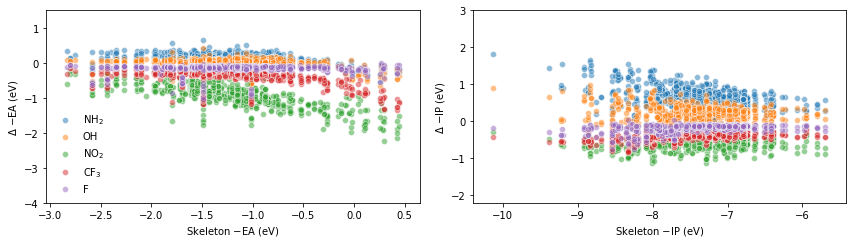

In [10]:
NH2 = data[(data['NH2'] == 1) & (data['total_subs'] == 1)]
NR2 = data[(data['NR2'] == 1) & (data['total_subs'] == 1)]
OH = data[(data['OH'] == 1) & (data['total_subs'] == 1)]
OR = data[(data['OR'] == 1) & (data['total_subs'] == 1)]
SH = data[(data['SH'] ==1) & (data['total_subs'] == 1)]
SR = data[(data['SR'] == 1) & (data['total_subs'] == 1)]
NO2 = data[(data['NO2'] == 1) & (data['total_subs'] == 1)]
CN = data[(data['CN'] == 1) & (data['total_subs'] == 1)]
SO3H = data[(data['SO3H'] == 1) & (data['total_subs'] == 1)]
CF3 = data[(data['CF3'] == 1) & (data['total_subs'] == 1)]
COOH = data[(data['COOH'] == 1) & (data['total_subs'] == 1)]
F = data[(data['F'] == 1) & (data['total_subs'] == 1)]

fig, ax = plt.subplots(1, 2, figsize=(12,3.5))

alpha=0.5
sns.scatterplot(NH2['EA_Skeleton'], NH2['Delta_EA'], label='NH$_2$', alpha=alpha, ax=ax[0])
sns.scatterplot(OH['EA_Skeleton'], OH['Delta_EA'], label='OH', alpha=alpha, ax=ax[0])
sns.scatterplot(NO2['EA_Skeleton'], NO2['Delta_EA'], label='NO$_2$', alpha=alpha, ax=ax[0])
sns.scatterplot(CF3['EA_Skeleton'], CF3['Delta_EA'], label='CF$_3$', alpha=alpha, ax=ax[0])
sns.scatterplot(F['EA_Skeleton'], F['Delta_EA'], label='F', alpha=alpha, ax=ax[0])

sns.scatterplot(NH2['IP_Skeleton'], NH2['Delta_IP'], label='NH$_2$', alpha=alpha, ax=ax[1])
sns.scatterplot(OH['IP_Skeleton'], OH['Delta_IP'], label='OH', alpha=alpha, ax=ax[1])
sns.scatterplot(NO2['IP_Skeleton'], NO2['Delta_IP'], label='NO$_2$', alpha=alpha, ax=ax[1])
sns.scatterplot(CF3['IP_Skeleton'], CF3['Delta_IP'], label='CF$_3$', alpha=alpha, ax=ax[1])
sns.scatterplot(F['IP_Skeleton'], F['Delta_IP'], label='F', alpha=alpha, ax=ax[1])

ax[0].set_xlabel('Skeleton $-$EA (eV)')
ax[1].set_xlabel('Skeleton $-$IP (eV)')

ax[0].set_ylabel('$\Delta$ $-$EA (eV)')
ax[1].set_ylabel('$\Delta$ $-$IP (eV)')

ax[0].legend(frameon=False)
ax[1].get_legend().remove()

ax[0].set_ylim(-4, 1.5)
ax[1].set_ylim(-2.2, 3.0)

plt.tight_layout()
plt.savefig('./all_figures/delta-skeleton-1sub.png', dpi=300, bbox_inches='tight')
plt.show()

#### Double substitution

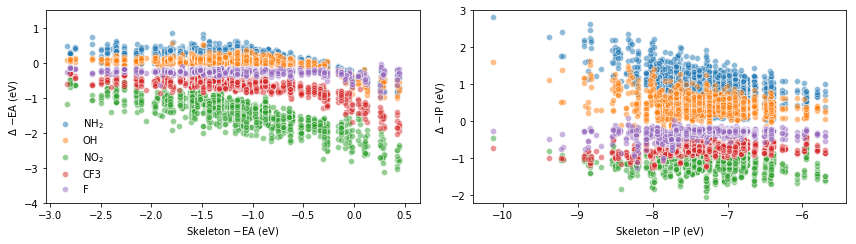

In [11]:
NH2 = data[(data['NH2'] == 2) & (data['total_subs'] == 2)]
NR2 = data[(data['NR2'] == 2) & (data['total_subs'] == 2)]
OH = data[(data['OH'] == 2) & (data['total_subs'] == 2)]
OR = data[(data['OR'] == 2) & (data['total_subs'] == 2)]
SH = data[(data['SH'] == 2) & (data['total_subs'] == 2)]
SR = data[(data['SR'] == 2) & (data['total_subs'] == 2)]
NO2 = data[(data['NO2'] == 2) & (data['total_subs'] == 2)]
CN = data[(data['CN'] == 2) & (data['total_subs'] == 2)]
SO3H = data[(data['SO3H'] == 2) & (data['total_subs'] == 2)]
CF3 = data[(data['CF3'] == 2) & (data['total_subs'] == 2)]
COOH = data[(data['COOH'] == 2) & (data['total_subs'] == 2)]
F = data[(data['F'] == 2) & (data['total_subs'] == 2)]

fig, ax = plt.subplots(1, 2, figsize=(12,3.5))

alpha=0.5
sns.scatterplot(NH2['EA_Skeleton'], NH2['Delta_EA'], label='NH$_2$', alpha=alpha, ax=ax[0])
sns.scatterplot(OH['EA_Skeleton'], OH['Delta_EA'], label='OH', alpha=alpha, ax=ax[0])
sns.scatterplot(NO2['EA_Skeleton'], NO2['Delta_EA'], label='NO$_2$', alpha=alpha, ax=ax[0])
sns.scatterplot(CF3['EA_Skeleton'], CF3['Delta_EA'], label='CF3', alpha=alpha, ax=ax[0])
sns.scatterplot(F['EA_Skeleton'], F['Delta_EA'], label='F', alpha=alpha, ax=ax[0])

sns.scatterplot(NH2['IP_Skeleton'], NH2['Delta_IP'], label='NH$_2$', alpha=alpha, ax=ax[1])
sns.scatterplot(OH['IP_Skeleton'], OH['Delta_IP'], label='OH', alpha=alpha, ax=ax[1])
sns.scatterplot(NO2['IP_Skeleton'], NO2['Delta_IP'], label='NO$_2$', alpha=alpha, ax=ax[1])
sns.scatterplot(CF3['IP_Skeleton'], CF3['Delta_IP'], label='CF$_3$', alpha=alpha, ax=ax[1])
sns.scatterplot(F['IP_Skeleton'], F['Delta_IP'], label='F', alpha=alpha, ax=ax[1])

ax[0].set_xlabel('Skeleton $-$EA (eV)')
ax[1].set_xlabel('Skeleton $-$IP (eV)')

ax[0].set_ylabel('$\Delta$ $-$EA (eV)')
ax[1].set_ylabel('$\Delta$ $-$IP (eV)')

ax[0].legend(frameon=False)
ax[1].get_legend().remove()

ax[0].set_ylim(-4, 1.5)
ax[1].set_ylim(-2.2, 3.0)

plt.tight_layout()
plt.savefig('./all_figures/delta-skeleton-2sub.png', dpi=300, bbox_inches='tight')
plt.show()

#### Skeleton topography (fixed to normalise by n times skeleton appears in total dataset)

c1nncc2nsnc12
c1nncc2oncc12
c1nnc[nH]1
c1c2c(cc3nsnc13)N=S=N2
O=C1C=CC(=O)C=C1
c1nncnn1
c1cncnc1
c1nnco1
Cn1c(=O)c2ccc3c4ccc5c(=O)n(C)c(=O)c6ccc(c7ccc(c1=O)c2c37)c4c56
c1nncc2cc3snnc3cc12
c1ccc2oncc2c1
c1ccc2cc3cc4ccccc4cc3cc2c1
c1ccc2c(c1)c1ccccc1c1ccccc21
c1cc[nH]c1
CC1(C)c2ccsc2-c2sccc21
c1cc2[nH]c3cc[nH]c3c2[nH]1


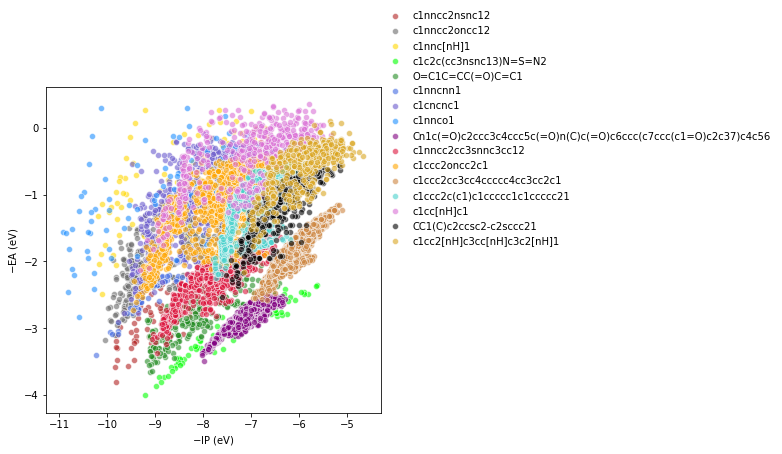

In [12]:
sns.set_palette("Spectral_r", 17)

x_limits = [-np.inf, -9., -8., -7., -6., np.inf]
y_limits = [-np.inf, -3.5, -2.5, -1.5, -0.5,  np.inf]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

c_list = ['firebrick', 'dimgrey', 'gold', 'lime', 'forestgreen', 'royalblue',
          'slateblue', 'dodgerblue', 'purple', 'crimson', 'orange', 'peru',
          'mediumturquoise', 'orchid', 'black', 'goldenrod', 'darkred']

prevalent_list = []
c_index = 0
counts_all_data = dict(data.Skeleton.value_counts())
for x in range(len(x_limits)-1):
    for y in range(len(y_limits)-1):
        in_area = data[(data.IP >= x_limits[x])&(data.IP <= x_limits[x+1])&(data.EA >= y_limits[y])&(data.EA <= y_limits[y+1])]
        if len(in_area) > 0:
            in_area_counts = dict(in_area.Skeleton.value_counts())
            for skel in in_area_counts.keys():
                in_area_counts[skel] = in_area_counts[skel]/counts_all_data[skel]
            
            prevalent = keywithmaxval(in_area_counts)
            if prevalent not in prevalent_list and prevalent not in ['c1ccccc1']:
                prevalent_list.append(prevalent)
                sub = data[data.Skeleton == prevalent]
                sns.scatterplot(sub['IP'], sub['EA'], label=prevalent, alpha=0.6, ax=ax, color=c_list[c_index])
                c_index += 1

ax.legend(frameon=False, loc=(1, 0.5))
ax.set_xlabel('$-$IP (eV)')
ax.set_ylabel('$-$EA (eV)')

plt.savefig('./all_figures/topography.png', dpi=300, bbox_inches='tight')
plt.show()

### Fingerprinting

In [13]:
rad = 1
bits = 4096

"""
''' create new fingerprints & image dict '''
data['fp'] = data.Smiles.apply(morgan, args=(rad, bits))
print('fps complete')
fp_image_dict = make_bit_image_dict(data.Smiles, rad, bits)
print('img dict complete')

''' save fingerprints & image dict to pickle '''
data.to_pickle('data-rad1-bits4096.pkl')
pickle_out = open('imgdict-rad1-bits4096.pkl','wb')
pickle.dump(fp_image_dict, pickle_out)
pickle_out.close()
"""
''' load fingerprints & image dict from pickle '''
data = pd.read_pickle('data-rad1-bits4096.pkl')
pickle_in = open('imgdict-rad1-bits4096.pkl','rb')
fp_image_dict = pickle.load(pickle_in)

#### Visualise Fragments

total set bits =  413


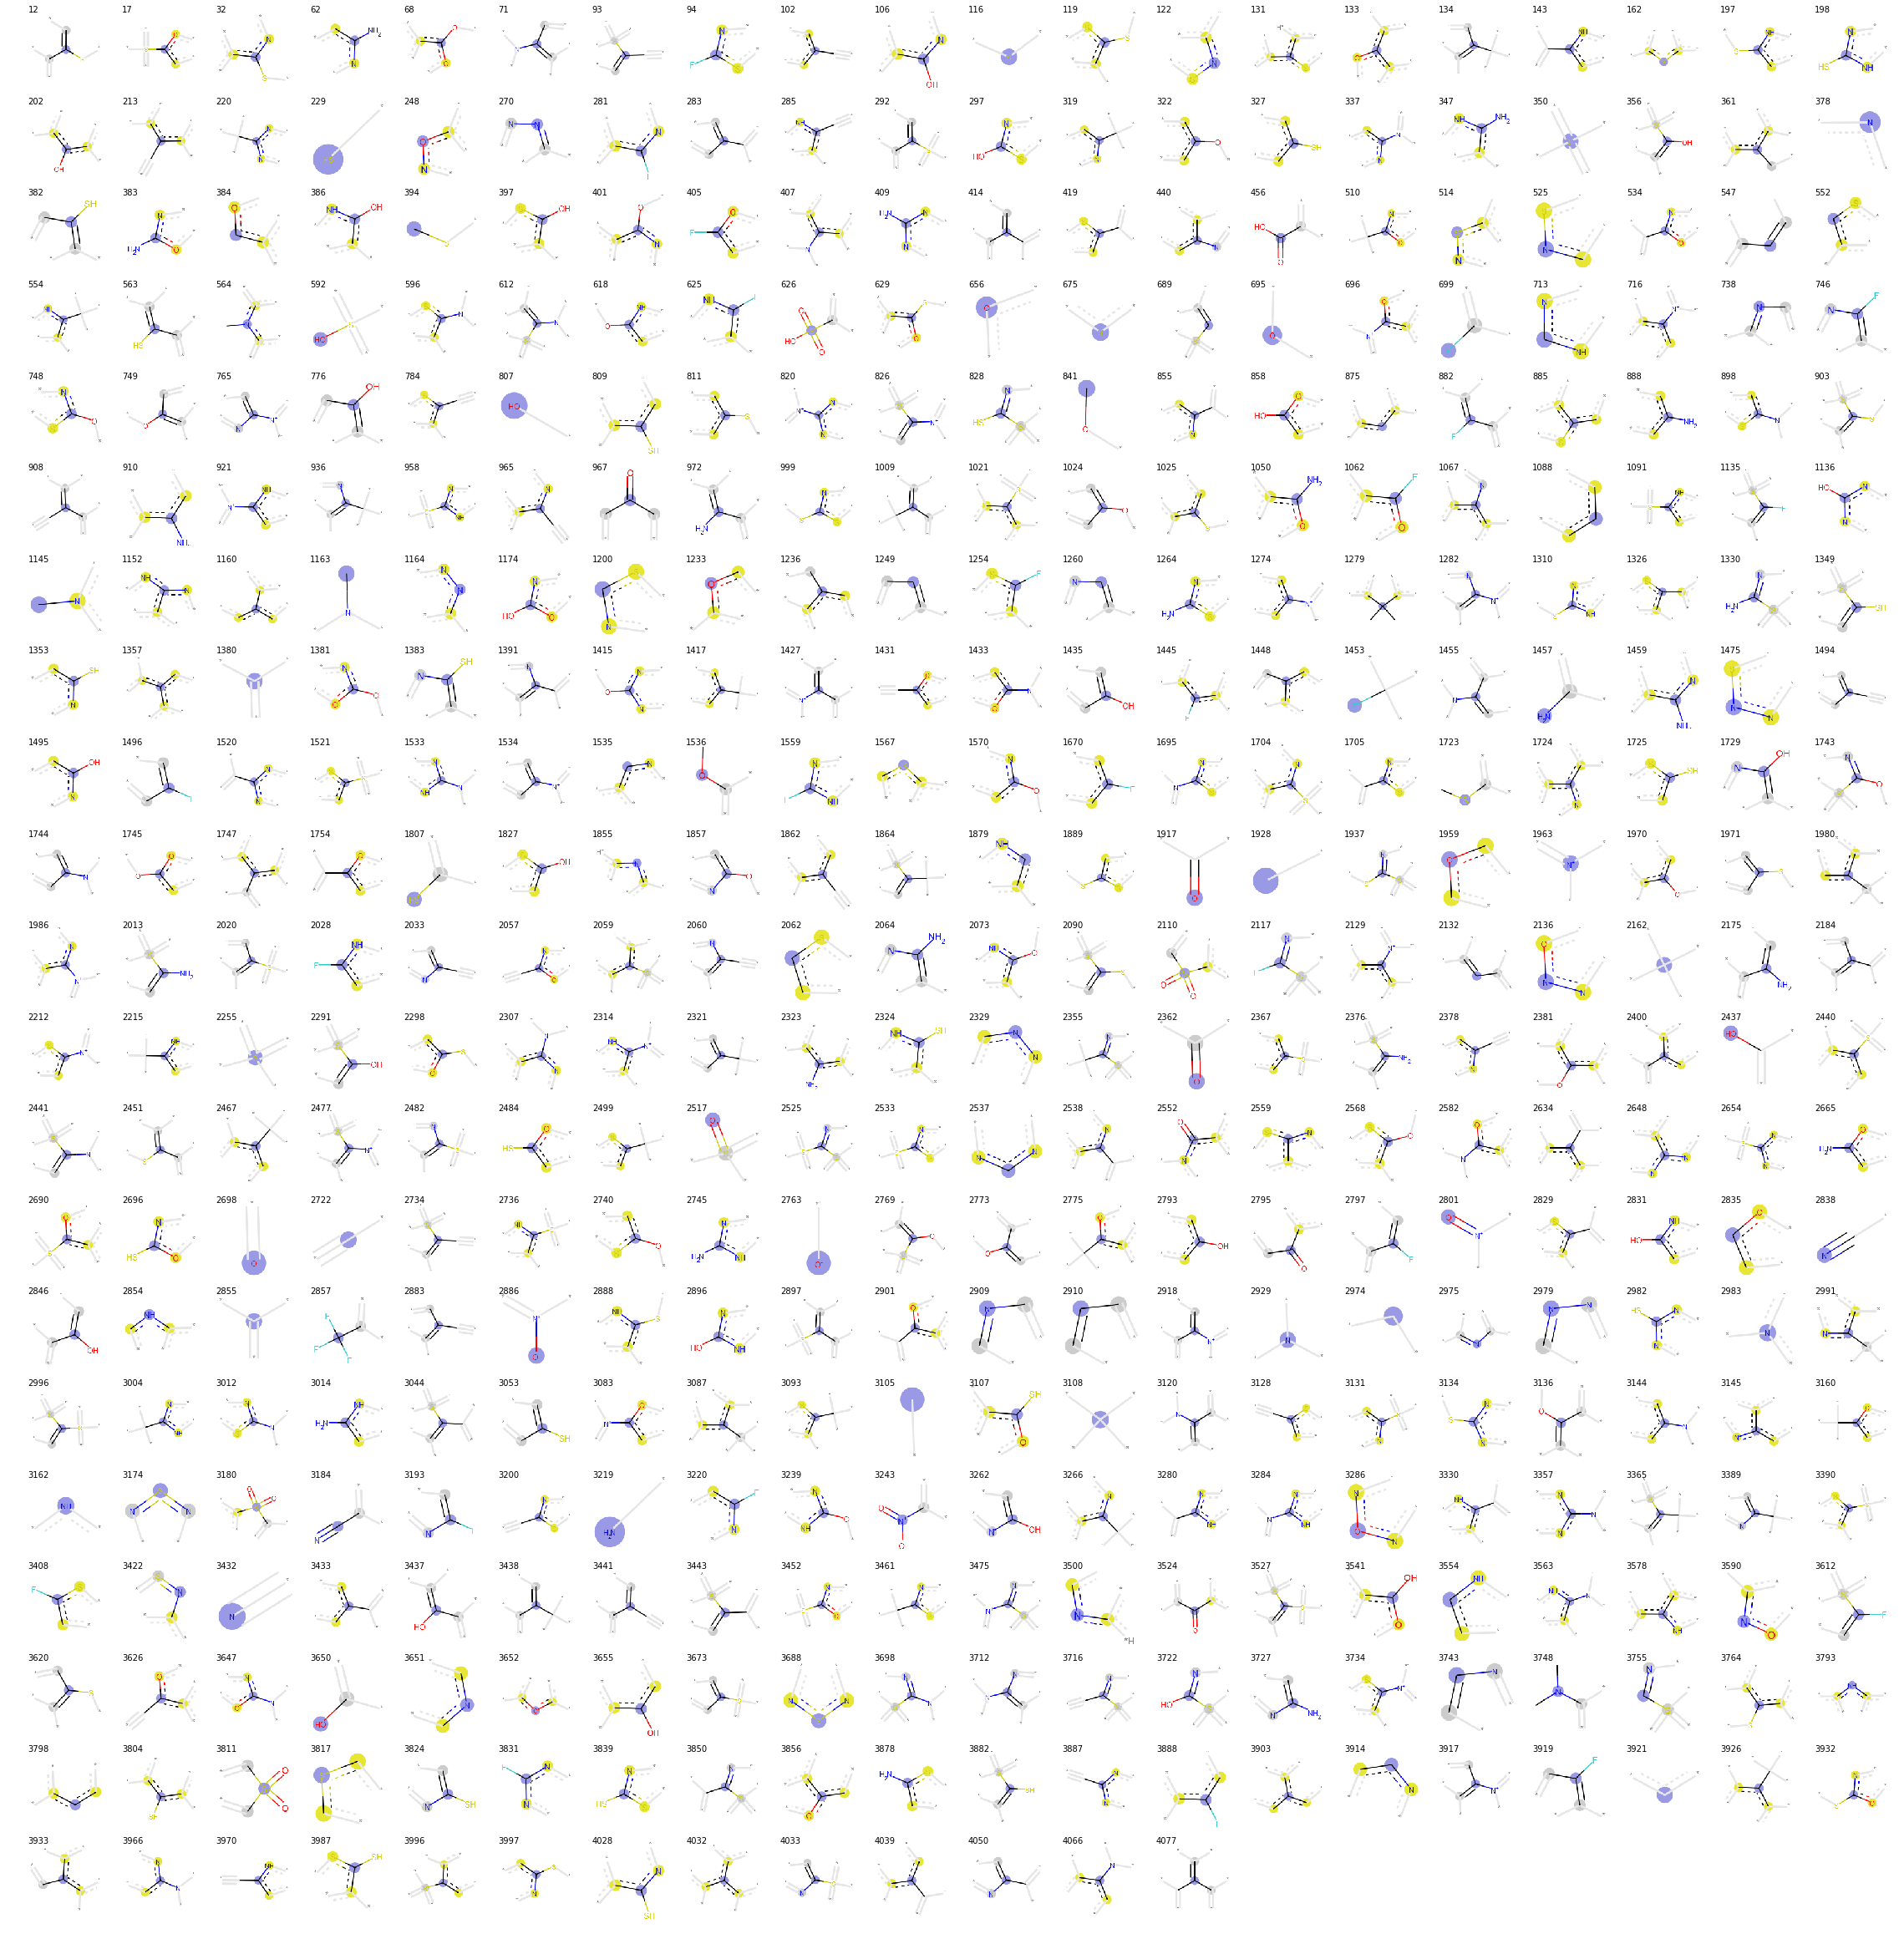

In [14]:
all_frags = list(fp_image_dict.keys())
all_frags.sort()
print('total set bits = ', len(all_frags))
display(all_frags, ncols=20, name='fragment_grid')

### Property Space

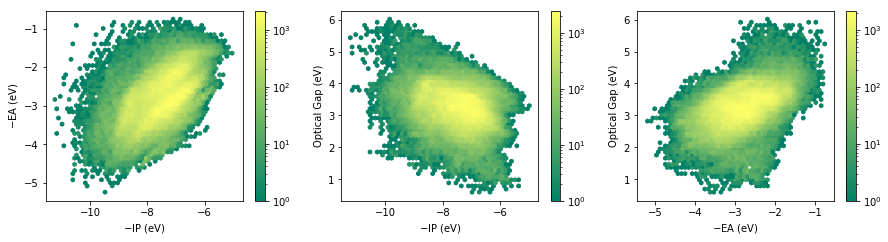

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

p = ax[0].hexbin(data.IP, data.EA, gridsize=50, cmap=plt.cm.summer, mincnt=1, norm=LogNorm())
plt.colorbar(p, ax=ax[0])

p = ax[1].hexbin(data.IP, data['S0->S1'], gridsize=50, cmap=plt.cm.summer, mincnt=1, norm=LogNorm())
plt.colorbar(p, ax=ax[1])

p = ax[2].hexbin(data.EA, data['S0->S1'], gridsize=50, cmap=plt.cm.summer, mincnt=1, norm=LogNorm())
plt.colorbar(p, ax=ax[2])

ax[0].set_xlabel('$-$IP (eV)')
ax[0].set_ylabel('$-$EA (eV)')

ax[1].set_xlabel('$-$IP (eV)')
ax[1].set_ylabel('Optical Gap (eV)')

ax[2].set_xlabel('$-$EA (eV)')
ax[2].set_ylabel('Optical Gap (eV)')

plt.savefig('./all_figures/property-spaces.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Fragment Analysis

#### functional groups


 NH2 NR2 OH OR
N =  55634
saving figure...


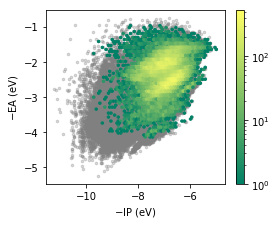

 NO2 CN SO3H CF3
N =  55529
saving figure...


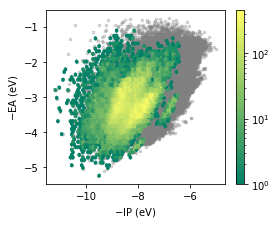

In [26]:
# NH2, NR2, OH, OR
strong_activ = {'NH2':1457, 'NR2':3748, 'OH':3650, 'OR':1536}
# SH, SR
mod_activ = {'SH':1807, 'SR':1723}

# NO2, CN, SO3H, CF3
strong_deactiv = {'NO2':3243, 'CN':3184, 'SO3H':626, 'CF3':2857}   
# COOH
mod_deactiv = {'COOH':456}

neither = {'F': 699}

all_fgs = {**strong_activ, **mod_activ, **strong_deactiv, **mod_deactiv, **neither}
all_activ = {**strong_activ, **mod_activ}
all_deactiv = {**strong_deactiv, **mod_deactiv}

plot_fragment_group(strong_activ, {**mod_activ, **all_deactiv}, 'IP', 'EA', '$-$IP (eV)', '$-$EA (eV)', name='strong-activ-only-ip-ea')
plot_fragment_group(strong_deactiv, {**mod_deactiv, **all_activ}, 'IP', 'EA', '$-$IP (eV)', '$-$EA (eV)', name='strong-deactiv-only-ip-ea')

 NH2 NR2 OH OR SH SR
N =  109359


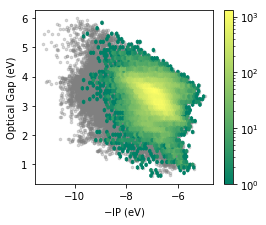

 NO2 CN SO3H CF3 COOH
N =  80183


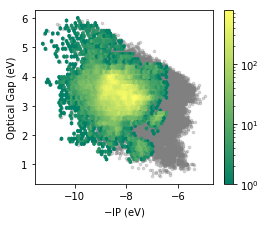

In [34]:
plot_fragment_group(all_activ, all_deactiv, 'IP', 'S0->S1', '$-$IP (eV)', 'Optical Gap (eV)', name='strong-activ-only-ip-og')
plot_fragment_group(all_deactiv, all_activ, 'IP', 'S0->S1', '$-$IP (eV)', 'Optical Gap (eV)', name='strong-deactiv-only-ip-og')

 NH2
N =  3106
saving figure...


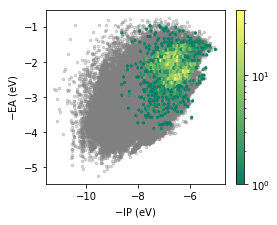

 NR2
N =  3095
saving figure...


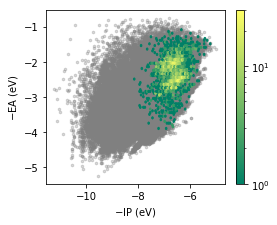

 OH
N =  3106
saving figure...


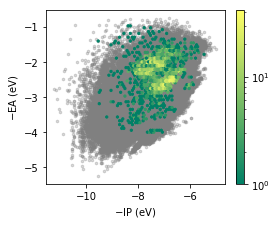

 OR
N =  3106
saving figure...


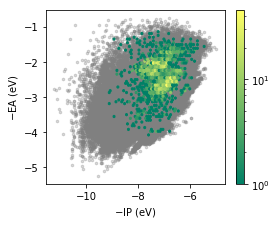

 SH
N =  3106
saving figure...


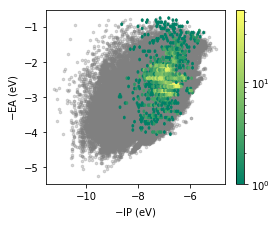

 SR
N =  3102
saving figure...


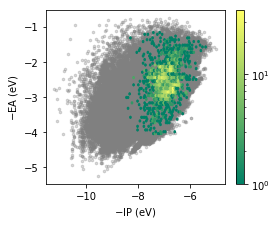

 NO2
N =  3097
saving figure...


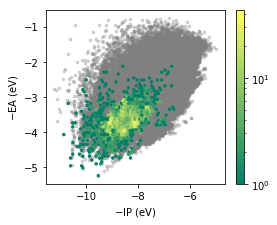

 CN
N =  3096
saving figure...


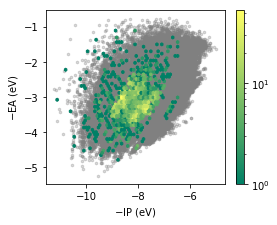

 SO3H
N =  3096
saving figure...


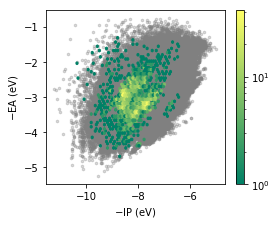

 CF3
N =  3096
saving figure...


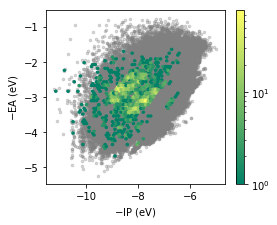

 COOH
N =  3096
saving figure...


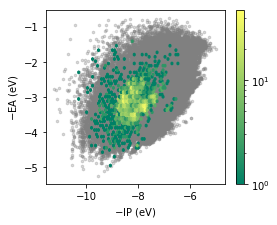

 F
N =  3106
saving figure...


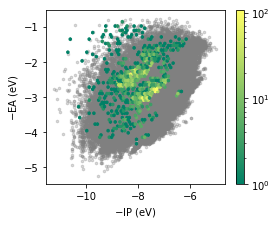

In [22]:
from copy import deepcopy

for key in all_fgs.keys():
    all_fgs_copy = deepcopy(all_fgs)
    val = all_fgs_copy.pop(key)
    plot_fragment_group({key: val}, all_fgs_copy, 'IP', 'EA', '$-$IP (eV)', '$-$EA (eV)', name=key+'-ip-ea')

 NH2
N =  3106


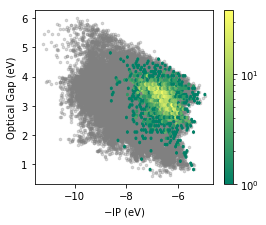

 NR2
N =  3095


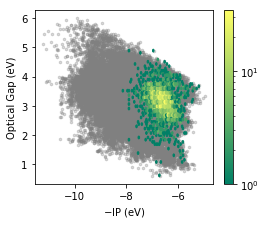

 OH
N =  3106


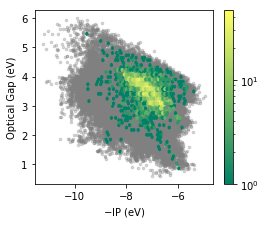

 OR
N =  3106


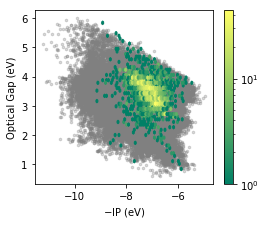

 SH
N =  3106


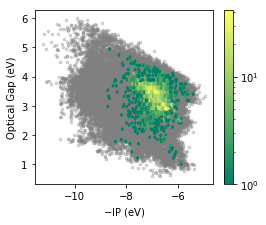

 SR
N =  3102


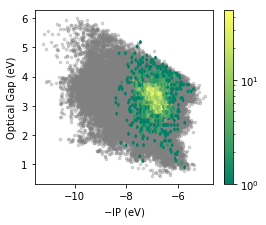

 NO2
N =  3097


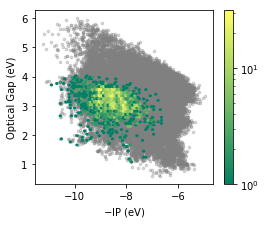

 CN
N =  3096


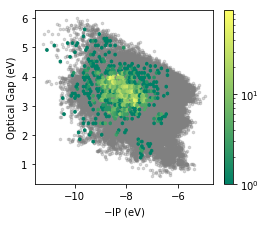

 SO3H
N =  3096


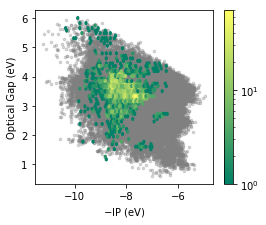

 CF3
N =  3096


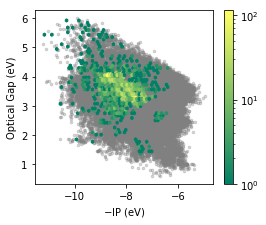

 COOH
N =  3096


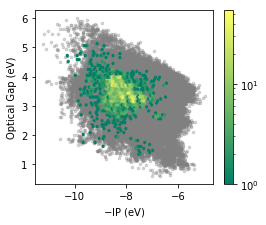

 F
N =  3106


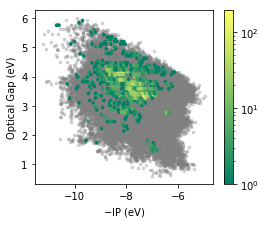

In [18]:
from copy import deepcopy

for key in all_fgs.keys():
    all_fgs_copy = deepcopy(all_fgs)
    val = all_fgs_copy.pop(key)
    plot_fragment_group({key: val}, all_fgs_copy, 'IP', 'S0->S1', '$-$IP (eV)', 'Optical Gap (eV)', name=key+'-ip-og')

#### heteroatoms

In [23]:
codons = {
         'c[H]-n[H]-c[H]': 3554,
         'c[H]-n[H]-c': 2854,
         'c-n[H]-c': 3793,
         'c[H]-o-c[H]': 1959,
         'c[H]-o-c': 1233,
         'c-o-c': 3652,

         'c[H]-s-c[H]': 3817,
         'c[H]-s-c': 1567,
         'c-s-c': 162,

         'c[H]-s[O2]-c[H]': 3811,
         'c[H]-s[O2]-c': 2110,
         'c-s[O2]-c': 3180,

         'c[H]-c(O)-c[H] ': 967,
         'c[H]-c(O)-c ': 2795,
         'c-c(O)-c ': 3524,

         'c[H]-n-c[H]': 3651,
         'c[H]-n-c ': 3500,
         'c-n-c': 1855,

         'c[H]-n-n': 2329,
         'c-n-n': 1164,
         'n-c[H]-n ': 2537,
         
         'n-s-n': 3688,
         'n-o-n': 3286,
         'n-n-s': 1475,
         'n-n-o': 2136,

         'c[H]-n-s': 525,
         'c[H]-n-o': 248,
    
         's-c[H]-n': 1200,
    
         'c[O]-n[C]-c[O]': 564 
         }


 c[H]-n[H]-c[H]
N =  1524
saving figure...


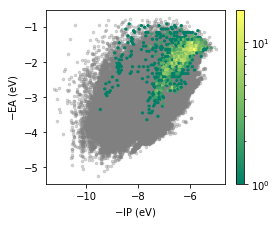

 c[H]-n[H]-c
N =  2854
saving figure...


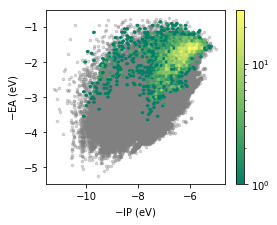

 c-n[H]-c
N =  5309
saving figure...


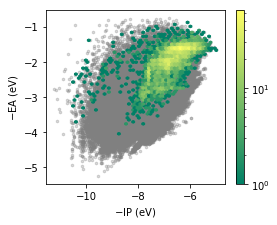

 c[H]-o-c[H]
N =  1863
saving figure...


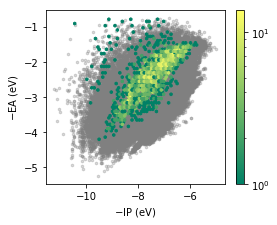

 c[H]-o-c
N =  7278
saving figure...


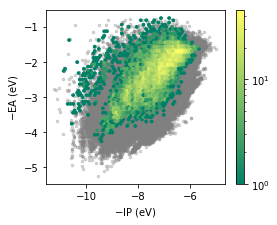

 c-o-c
N =  6706
saving figure...


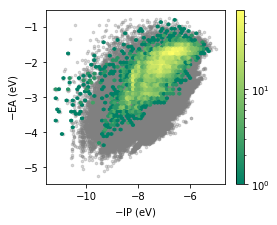

 c[H]-s-c[H]
N =  1863
saving figure...


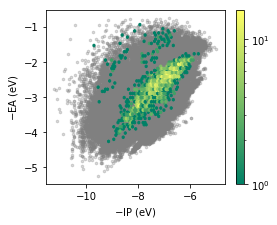

 c[H]-s-c
N =  8099
saving figure...


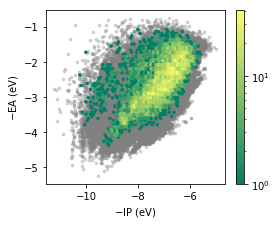

 c-s-c
N =  7732
saving figure...


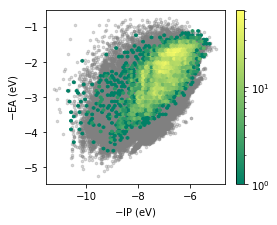

 c[H]-s[O2]-c[H]
N =  105
saving figure...


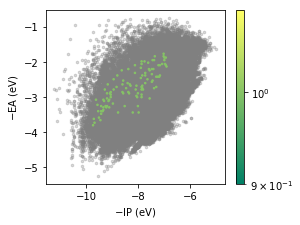

 c[H]-s[O2]-c
N =  1681
saving figure...


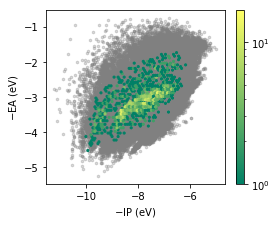

 c-s[O2]-c
N =  3524
saving figure...


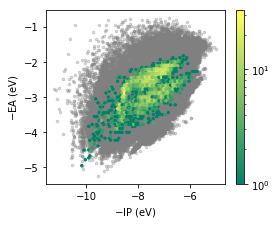

 c[H]-c(O)-c[H] 
N =  91
saving figure...


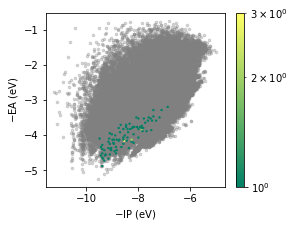

 c[H]-c(O)-c 
N =  1224
saving figure...


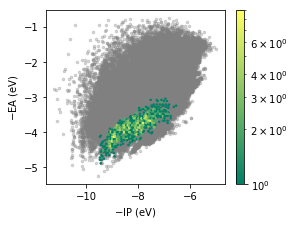

 c-c(O)-c 
N =  53823
saving figure...


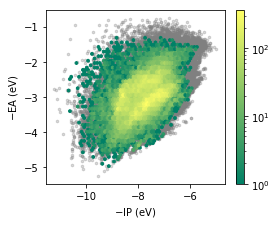

 c[H]-n-c[H]
N =  48002
saving figure...


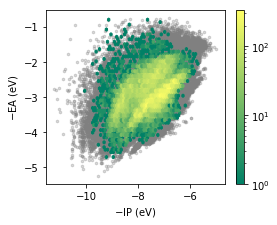

 c[H]-n-c 
N =  168966
saving figure...


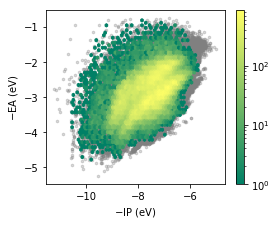

 c-n-c
N =  61658
saving figure...


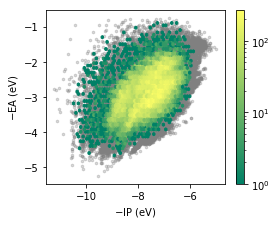

 c[H]-n-n
N =  10822
saving figure...


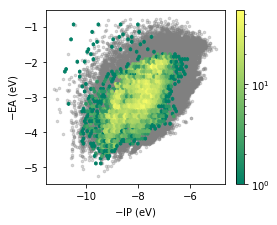

 c-n-n
N =  22753
saving figure...


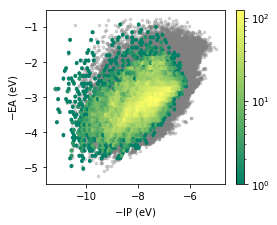

 n-c[H]-n 
N =  3246
saving figure...


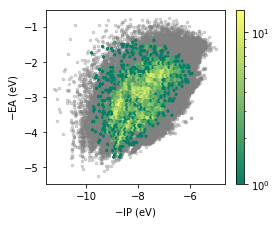

 n-s-n
N =  4225
saving figure...


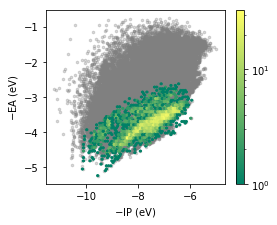

 n-o-n
N =  4134
saving figure...


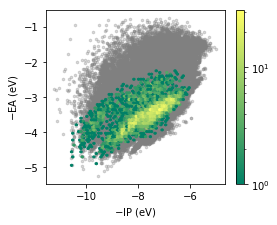

 n-n-s
N =  6198
saving figure...


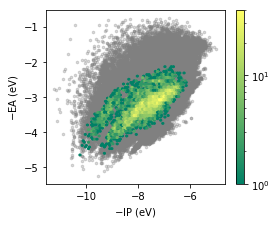

 n-n-o
N =  6198
saving figure...


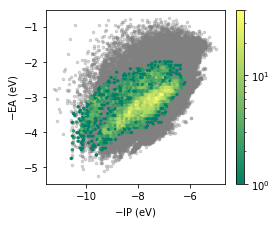

 c[H]-n-s
N =  6198
saving figure...


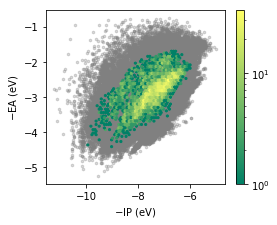

 c[H]-n-o
N =  15924
saving figure...


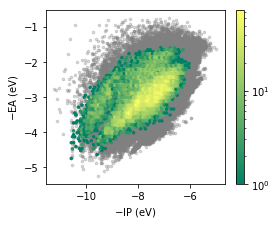

 s-c[H]-n
N =  221
saving figure...


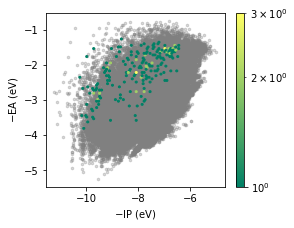

 c[O]-n[C]-c[O]
N =  1311
saving figure...


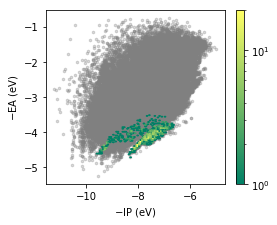

In [24]:
for key in codons.keys():
    codons_copy = deepcopy(codons)
    val = codons_copy.pop(key)
    plot_fragment_group({key: val}, {}, 'IP', 'EA', '$-$IP (eV)', '$-$EA (eV)', name=key+'-ip-ea')

 c[H]-n[H]-c[H]
N =  1524
saving figure...


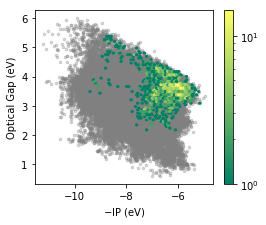

 c[H]-n[H]-c
N =  2854
saving figure...


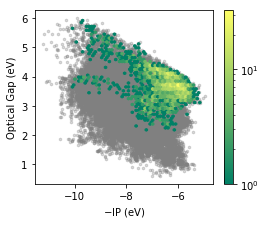

 c-n[H]-c
N =  5309
saving figure...


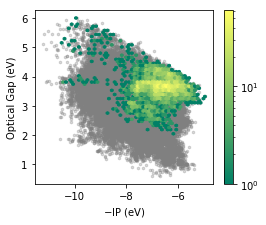

 c[H]-o-c[H]
N =  1863
saving figure...


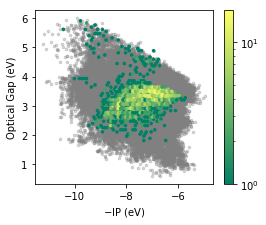

 c[H]-o-c
N =  7278
saving figure...


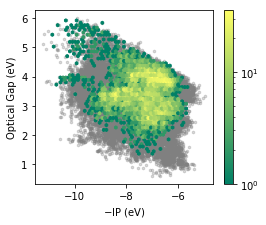

 c-o-c
N =  6706
saving figure...


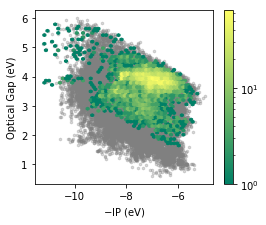

 c[H]-s-c[H]
N =  1863
saving figure...


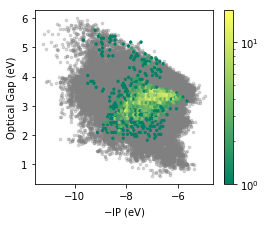

 c[H]-s-c
N =  8099
saving figure...


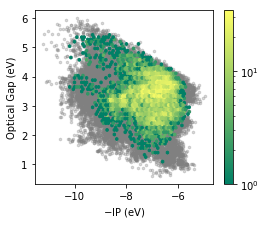

 c-s-c
N =  7732
saving figure...


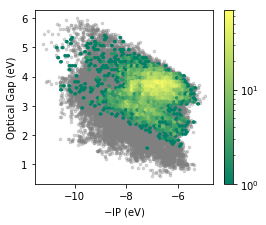

 c[H]-s[O2]-c[H]
N =  105
saving figure...


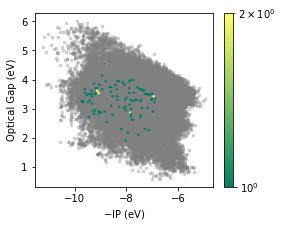

 c[H]-s[O2]-c
N =  1681
saving figure...


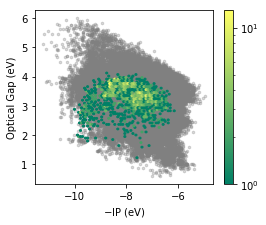

 c-s[O2]-c
N =  3524
saving figure...


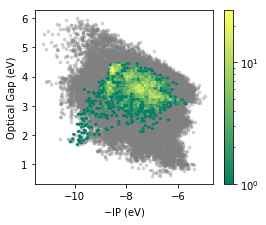

 c[H]-c(O)-c[H] 
N =  91
saving figure...


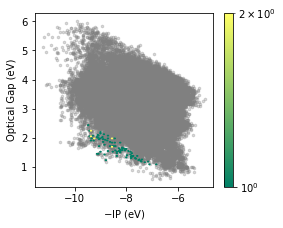

 c[H]-c(O)-c 
N =  1224
saving figure...


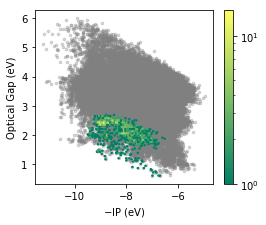

 c-c(O)-c 
N =  53823
saving figure...


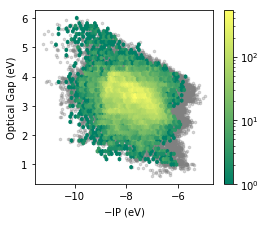

 c[H]-n-c[H]
N =  48002
saving figure...


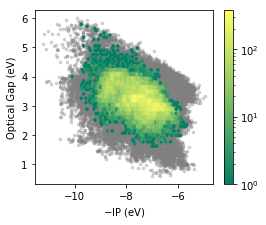

 c[H]-n-c 
N =  168966
saving figure...


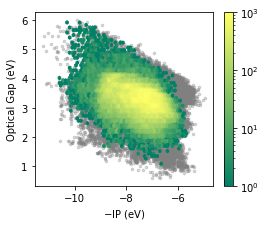

 c-n-c
N =  61658
saving figure...


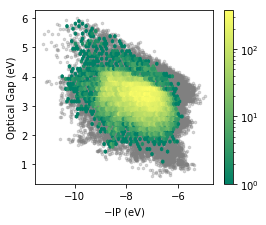

 c[H]-n-n
N =  10822
saving figure...


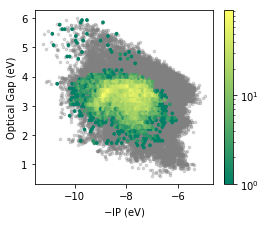

 c-n-n
N =  22753
saving figure...


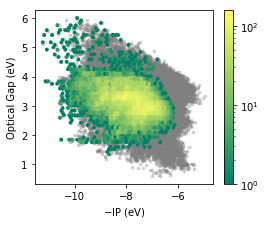

 n-c[H]-n 
N =  3246
saving figure...


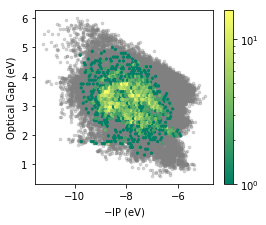

 n-s-n
N =  4225
saving figure...


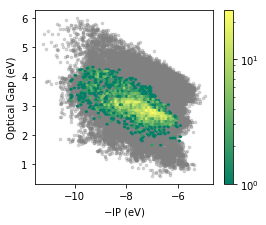

 n-o-n
N =  4134
saving figure...


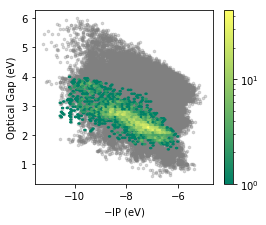

 n-n-s
N =  6198
saving figure...


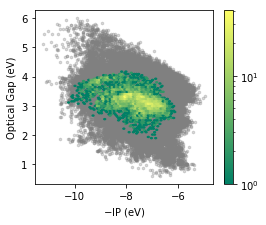

 n-n-o
N =  6198
saving figure...


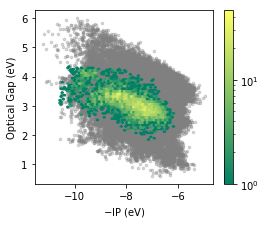

 c[H]-n-s
N =  6198
saving figure...


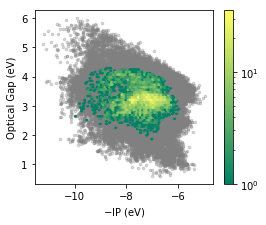

 c[H]-n-o
N =  15924
saving figure...


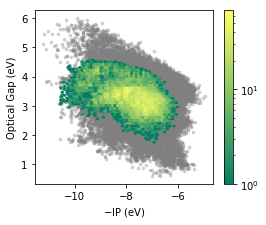

 s-c[H]-n
N =  221
saving figure...


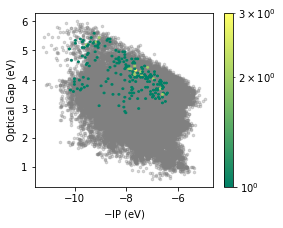

 c[O]-n[C]-c[O]
N =  1311
saving figure...


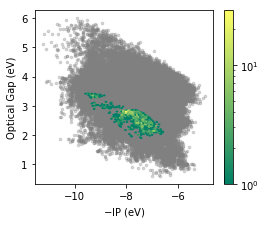

In [25]:
for key in codons.keys():
    codons_copy = deepcopy(codons)
    val = codons_copy.pop(key)
    plot_fragment_group({key: val}, {}, 'IP', 'S0->S1', '$-$IP (eV)', 'Optical Gap (eV)', name=key+'ip-og')

### Ring count

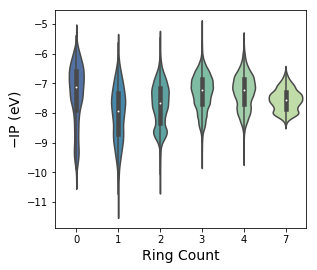

In [41]:
data['n_rings'] = data.Smiles.apply(calc_rings)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
sns.violinplot(x='n_rings', y='IP', data=data, ax=ax)
ax.set_xlabel('Ring Count', fontsize=14)
ax.set_ylabel('$-$IP (eV)', fontsize=14)
plt.savefig('./all_figures/ring-count-ip.jpg', dpi=300, bbox_inches='tight')
plt.show()

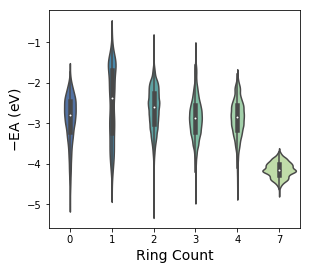

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
sns.violinplot(x='n_rings', y='EA', data=data, ax=ax)
ax.set_xlabel('Ring Count', fontsize=14)
ax.set_ylabel('$-$EA (eV)', fontsize=14)
plt.savefig('./all_figures/ring-count-ea.jpg', dpi=300, bbox_inches='tight')
plt.show()

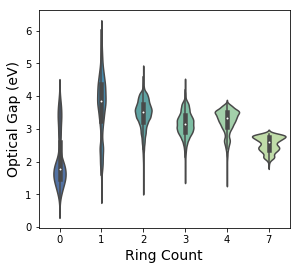

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
sns.violinplot(x='n_rings', y='S0->S1', data=data, ax=ax)
ax.set_xlabel('Ring Count', fontsize=14)
ax.set_ylabel('Optical Gap (eV)', fontsize=14)
plt.savefig('./all_figures/ring-count-og.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Convex Hulls

In [52]:
data_unsub = data[data.total_subs == 0]

def plot(data, x, y, xlabel, ylabel, axis):
    
    p = axis.hexbin(data[x], data[y], gridsize=70, cmap=plt.cm.afmhot, norm=LogNorm(), mincnt=1)
    axis.scatter(data_unsub[x], data_unsub[y], c='b', s=8, alpha=0.9, marker='h')

    axis.set_xlabel(xlabel, fontsize=14)
    axis.set_ylabel(ylabel, fontsize=14)
    plt.colorbar(p, ax=axis)

    points = np.zeros((len(data_unsub), 2))
    points[:,0], points[:,1] = data_unsub[y], data_unsub[x]
    hull = ConvexHull(points, 2)
    for simplex in hull.simplices:
        axis.plot(points[simplex, 1], points[simplex, 0], 'k-', c='b', linewidth=2.0)        
        
        
def plot_hulls(df_list, x, y, xlabel, ylabel, axis):
    
    axis.set_xlabel(xlabel, fontsize=14)
    axis.set_ylabel(ylabel, fontsize=14)

    clist = ['r', 'b', 'g', 'black']
    i = 0
    for df in df_list:
        points = np.zeros((len(df), 2))
        points[:,0], points[:,1] = df[y], df[x]
        hull = ConvexHull(points, 2)
        for simplex in hull.simplices:
            axis.plot(points[simplex, 1], points[simplex, 0], 'k-', c=clist[i], linewidth=2.0)    
        i += 1

In [53]:
no_hets = return_subgroup(data, all_frags, codons.values())
no_subs = return_subgroup(data, all_frags, all_fgs.values())
no_hets_no_subs = return_subgroup(no_hets, all_frags, all_fgs.values())

#### Substituents only

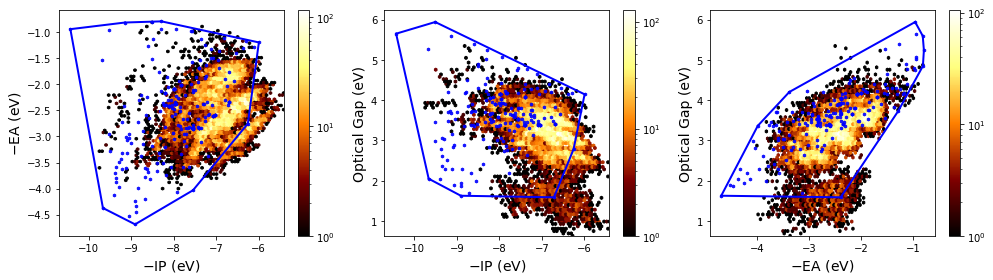

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot(no_hets, 'IP', 'EA', '$-$IP (eV)', '$-$EA (eV)', axes[0])
plot(no_hets, 'IP', 'S0->S1', '$-$IP (eV)', 'Optical Gap (eV)', axes[1])
plot(no_hets, 'EA', 'S0->S1', '$-$EA (eV)', 'Optical Gap (eV)', axes[2])
plt.tight_layout()
plt.savefig('convex-hulls-substituents.jpg')
plt.show()

#### Heteroatoms and Substituents

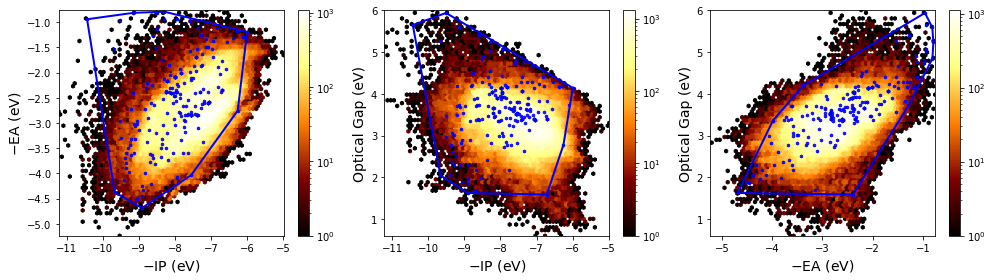

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot(data, 'IP', 'EA', '$-$IP (eV)', '$-$EA (eV)', axes[0])
plot(data, 'IP', 'S0->S1', '$-$IP (eV)', 'Optical Gap (eV)', axes[1])
plot(data, 'EA', 'S0->S1', '$-$EA (eV)', 'Optical Gap (eV)', axes[2])
plt.tight_layout()
plt.savefig('convex-hulls-all.jpg')
plt.show()

#### Convex Hulls Only

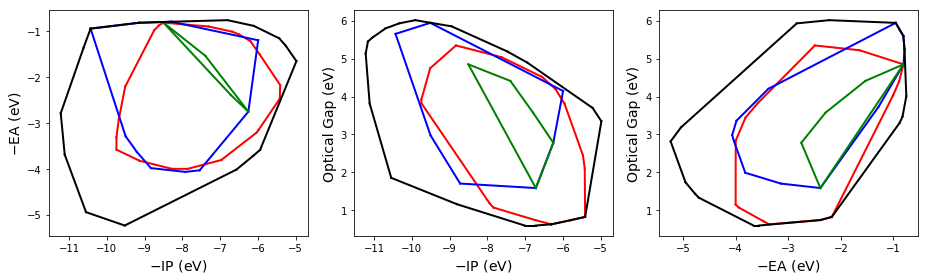

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plot_hulls([no_hets, no_subs, no_hets_no_subs, data], 'IP', 'EA', '$-$IP (eV)', '$-$EA (eV)', axes[0])
plot_hulls([no_hets, no_subs, no_hets_no_subs, data], 'IP', 'S0->S1', '$-$IP (eV)', 'Optical Gap (eV)', axes[1])
plot_hulls([no_hets, no_subs, no_hets_no_subs, data], 'EA', 'S0->S1', '$-$EA (eV)', 'Optical Gap (eV)', axes[2])
plt.tight_layout()
plt.savefig('convex-hulls-combined.jpg', dpi=300)
plt.show()

### KDE Plots

#### Activating vs Deactivating

In [48]:
activ_df = return_subgroup(data, strong_activ.values(), strong_deactiv.values())
deactiv_df = return_subgroup(data, strong_deactiv.values(), strong_activ.values())

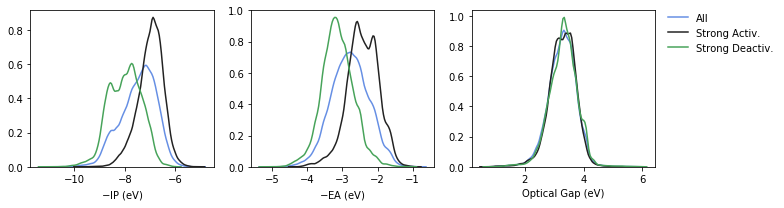

In [69]:
sns.set_palette(sns.diverging_palette(255, 133, l=60, n=3, center="dark"))

fig, ax = plt.subplots(1, 3, figsize=(11, 3))

sns.kdeplot(data.IP, ax=ax[0], legend=False)
sns.kdeplot(activ_df.IP, ax=ax[0], legend=False)
sns.kdeplot(deactiv_df.IP, ax=ax[0], legend=False)

sns.kdeplot(data.EA, ax=ax[1], legend=False)
sns.kdeplot(activ_df.EA, ax=ax[1], legend=False)
sns.kdeplot(deactiv_df.EA, ax=ax[1], legend=False)

sns.kdeplot(data['S0->S1'], ax=ax[2], label='All')
sns.kdeplot(activ_df['S0->S1'], ax=ax[2], label='Strong Activ.')
sns.kdeplot(deactiv_df['S0->S1'], ax=ax[2], label='Strong Deactiv.')

ax[2].legend(loc=(1.05, 0.7), frameon=False)

ax[0].set_xlabel('$-$IP (eV)')
ax[1].set_xlabel('$-$EA (eV)')
ax[2].set_xlabel('Optical Gap (eV)')
    
plt.tight_layout()
plt.savefig('./all_figures/kde-plots.jpg', dpi=300, bbox_inches='tight')
plt.show()

#### KDE Single vs Double Substitution

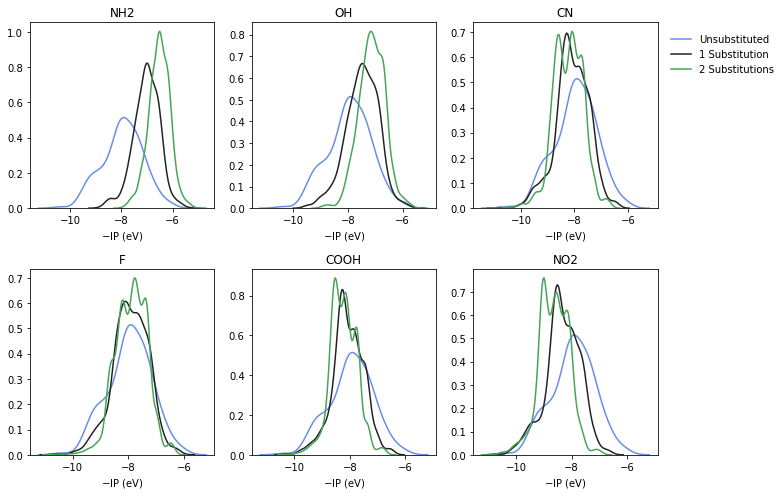

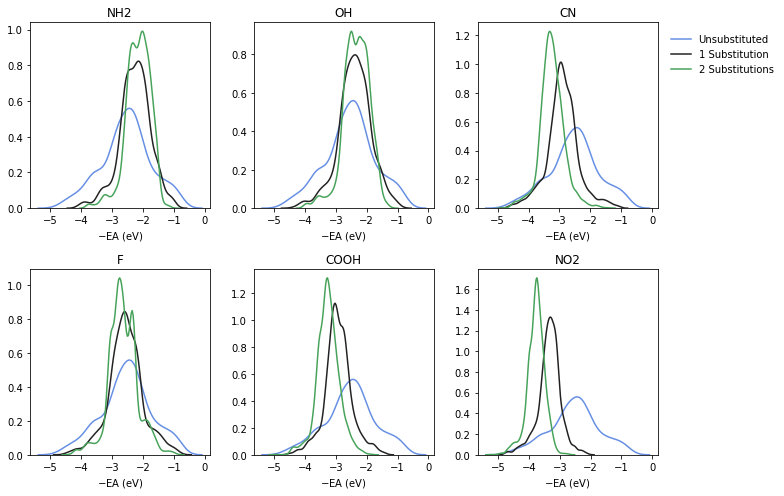

In [70]:
NONE = data[data['total_subs'] == 0]
NH2_1 = data[(data['NH2'] == 1) & (data['total_subs'] == 1)]
NH2_2 = data[(data['NH2'] == 2) & (data['total_subs'] == 2)]

CN_1 = data[(data['CN'] == 1) & (data['total_subs'] == 1)]
CN_2 = data[(data['CN'] == 2) & (data['total_subs'] == 2)]

OH_1 = data[(data['OH'] == 1) & (data['total_subs'] == 1)]
OH_2 = data[(data['OH'] == 2) & (data['total_subs'] == 2)]

F_1 = data[(data['F'] == 1) & (data['total_subs'] == 1)]
F_2 = data[(data['F'] == 2) & (data['total_subs'] == 2)]

COOH_1 = data[(data['COOH'] == 1) & (data['total_subs'] == 1)]
COOH_2 = data[(data['COOH'] == 2) & (data['total_subs'] == 2)]

NO2_1 = data[(data['NO2'] == 1) & (data['total_subs'] == 1)]
NO2_2 = data[(data['NO2'] == 2) & (data['total_subs'] == 2)]

subs_1 = [NH2_1, OH_1, CN_1, F_1, COOH_1, NO2_1]
subs_2 = [NH2_2, OH_2, CN_2, F_2, COOH_2, NO2_2]
names = ['NH2', 'OH', 'CN', 'F', 'COOH', 'NO2']

for prop in ['IP', 'EA']:
    fig, ax = plt.subplots(2, 3, figsize=(11, 7))

    i = 0
    j = 0
    k = 0
    for i in range(2):
        for j in range(3):
            ax[i][j].set_title(names[k])
            ax[i][j].set_xlabel(f'$-${prop} (eV)')
            sns.kdeplot(NONE[prop], ax=ax[i][j], legend=False, label='Unsubstituted')
            sns.kdeplot(subs_1[k][prop], ax=ax[i][j], legend=False, label='1 Substitution')
            sns.kdeplot(subs_2[k][prop], ax=ax[i][j], legend=False, label='2 Substitutions')
            k += 1
            j += 1
        i += 1

    ax[0][2].legend(loc=(1.05, 0.7), frameon=False)

    plt.tight_layout()
    plt.savefig(f'./all_figures/kde_nsub_{prop}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
